# DKRZ Tutorial: &nbsp; &nbsp; How to use a shapefile to mask your data

----

```
Copyright 2022 Deutsches Klimarechenzentrum GmbH (DKRZ)
Licensed under CC-BY-NC-SA-4.0
```

----

In the field of data analysis and visualization, in some cases you want to use or display only the data of a certain geographical region. Selecting data of a certain region can be done, among other things, with the help of a shapefile for this region. Shapefiles contain georeferenced points, lines, polygons, and/or area features and can be downloaded from different sites.

In this tutorial we will use the topography data generated with CDO as input data. In the first example we extract and draw data for a single country using the countries.shp file and in the second example we use two shapefiles for Germany to mask the data of various German states.

**Content**

1. Import Python packages
1. Example data
1. In general
   1. Shapefile content
   1. Plotting
1. Example 1: Extract the data for one state only
   1. Generate the mask
   1. Mask the data
   1. Plotting
   1. Set projection (CRS)
1. Example 2: Extract the data for German states
   1. Generate the mask
   1. Mask the data
   1. Plotting
   1. Get center position of a state
   1. Set projection (CRS)
   1. Plotting: Add state names and border lines


**Shapefile description**

From the _ESRI Shapefile Technical Description_ <br>
https://www.esri.com/content/dam/esrisites/sitecore-archive/Files/Pdfs/library/whitepapers/pdfs/shapefile.pdf

> A shapefile stores nontopological geometry and attribute information for the spatial
features in a data set. The geometry for a feature is stored as a shape comprising a set of
vector coordinates.
> 
> Because shapefiles do not have the processing overhead of a topological data structure,
they have advantages over other data sources such as faster drawing speed and edit
ability. Shapefiles handle single features that overlap or that are noncontiguous. They
also typically require less disk space and are easier to read and write.
> 
> Shapefiles can support point, line, and area features. Area features are represented as
closed loop, double-digitized polygons. Attributes are held in a dBASE® format file.
Each attribute record has a one-to-one relationship with the associated shape record.

**Shapefiles used**
- countries_shp/countries.shp 
- gadm36_DEU_shp/gadm36_DEU_0.shp
- gadm36_DEU_shp/gadm36_DEU_1.shp

**Learning content**
- Read shapefile content
- Extract polygon data of the choosen shapefile content
- Mask the variable data with the mask array
- Plot the masked data

**Shapefile download sites:**
- https://sourceforge.net/projects/countriesshp/
- https://gadm.org

----

## Import Python packages

In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
import regionmask
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from cdo import Cdo
cdo = Cdo()

## Example data

The example data used here is the topography data generated with CDO's `topo` operator and a grid resolution of 0.1°x0.1°. Using `returnXDatset=True` and no `output` parameter the result is returned as an Xarray Dataset.

In [2]:
ds_topo = cdo.remapbil('global_0.1', input='-topo', returnXDataset=True)
ds_topo

<xarray.Dataset>
Dimensions:  (lon: 3600, lat: 1800)
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    topo     (lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Nov 07 17:36:24 2023: cdo -O -s -f nc -remapbil,global_...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

Use variable _topo_ from the Dataset and display the example data.

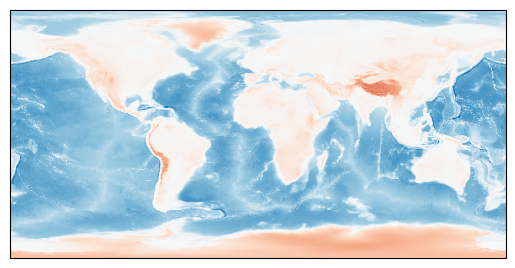

In [3]:
var = ds_topo['topo']

var.plot(add_colorbar=False, transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.PlateCarree()});

## In general

### Shapefile content

GeoPandas provide the function geopandas.read_file() that reads among others a shapefile and returns a GeoDataFrame which is similar to a Pandas Dataframe.

In [4]:
content = gpd.read_file('./countries_shp/countries.shp')

Print first few rows of the GeoDataFrame.

In [5]:
content.head()      # print only first 5 rows

#display(content)    # print all

OBJECTID            NAME ISO3 ISO2 FIPS         COUNTRY         ENGLISH  \
0         1           Åland  ALA   AX   AX           Åland           Åland   
1         2     Afghanistan  AFG   AF   AF     Afghanistan     Afghanistan   
2         3         Albania  ALB   AL   AL         Albania         Albania   
3         4         Algeria  DZA   DZ   AG         Algeria         Algeria   
4         5  American Samoa  ASM   AS   AQ  American Samoa  American Samoa   

              FRENCH          SPANISH           LOCAL             FAO WAS_ISO  \
0                NaN              NaN           Åland             NaN     NaN   
1        Afghanistan       Afganistán     Afghanestan     Afghanistan     NaN   
2            Albanie          Albania       Shqiperia         Albania     NaN   
3            Algérie          Argelia      Al Jaza'ir         Algeria     NaN   
4  Samoa Américaines  Samoa Americana  American Samoa  American Samoa     NaN   

       SOVEREIGN CONTINENT           UNREG1   UNREG2  EU          SQKM  \
0        Finland    Europe  Northern Europe   Europe   0  1.243719e+03   
1    Afghanistan      Asia    Southern Asia     Asia   0  6.413834e+05   
2        Albania    Europe  Southern Europe   Europe   0  2.848611e+04   
3        Algeria    Africa  Northern Africa   Africa   0  2.316559e+06   
4  United States   Oceania        Polynesia  Oceania   0  2.110151e+02   

                                            geometry  
0  MULTIPOLYGON (((20.99567 60.64228, 20.99261 60...  
1  POLYGON ((73.27336 36.88856, 73.26195 36.89025...  
2  MULTIPOLYGON (((20.98057 40.85522, 20.98096 40...  
3  MULTIPOLYGON (((-8.67387 27.29807, -8.67172 27...  
4  MULTIPOLYGON (((-171.07492 -11.06860, -171.078...

### Plotting

First, let's see what kind of CRS (Coordinate Reference System) is set for _content_. The attribute `crs` of the GeoDataFRame returns the CRS.

In [6]:
content.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The returned content variable is a GeoDataframe which can be plotted using the GeoPandas plot() method.

<AxesSubplot: >

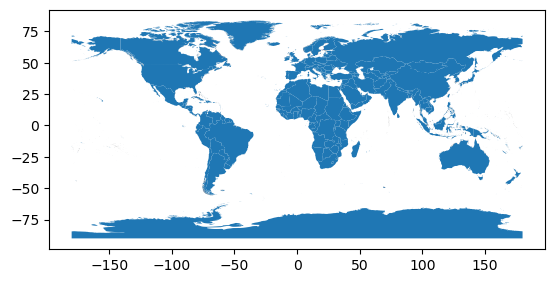

In [7]:
content.plot()

<br>

## Example 1: Extract the data for one state only

Let's start from the beginning and read the shapefile content into a GeoDataFrame.

In [8]:
shp_file = './countries_shp/countries.shp'

In [9]:
content = gpd.read_file(shp_file)

type(content)

geopandas.geodataframe.GeoDataFrame

The country names are stored in the column _NAME_ of the GeoDataFrame.

In [10]:
shp_var = 'NAME'

Get the list of all countries.

In [11]:
country_names = [ x for x in content[shp_var]]
#print(country_names)

We want to use only one country therefore we assign a variable _name_ that keeps the chosen country name.

In [12]:
name = 'Canada'

Check if the chosen country is in the GeoDataFrame (read from the shapefile), check if it is a substring (e.g. 'Republic') and would fit to multiple countries.

In [13]:
ncheck = [n for n in country_names if name in n]

if ncheck == []:
    raise NameError(f'ERROR: "{name}" not found in shapefile')
elif len(ncheck) > 1:
    raise NameError(f'ERROR: found multiple entries for "{name}" in shapefile\n                  {ncheck}')
else:
    print(ncheck)

['Canada']


Extract the data of the chosen country from the GeoDataFrame.

In [14]:
df = content.loc[content['NAME'] == name]
df

OBJECTID    NAME ISO3 ISO2 FIPS COUNTRY ENGLISH  FRENCH SPANISH   LOCAL  \
43        44  Canada  CAN   CA   CA  Canada  Canada  Canada  Canadá  Canada   

       FAO WAS_ISO SOVEREIGN      CONTINENT            UNREG1    UNREG2  EU  \
43  Canada     NaN    Canada  North America  Northern America  Americas   0   

            SQKM                                           geometry  
43  9.924777e+06  MULTIPOLYGON (((-62.53519 82.01356, -62.57449 ...

Have a look at the extracted country.

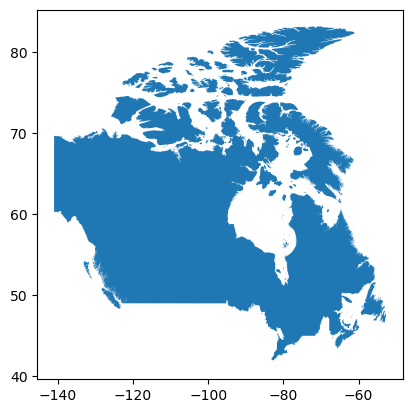

In [15]:
df.plot();

### Plotting

In the next step, we draw the multipolygon of the selected country on top of the example _topo_ plot.

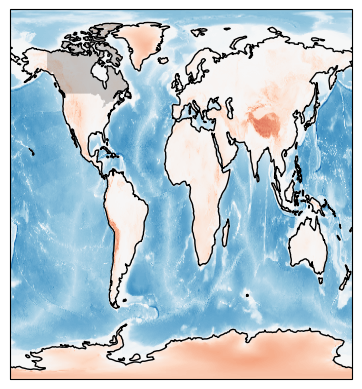

In [16]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
var.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), zorder=0)
df.plot(ax=ax, alpha=0.2, color='black', transform=ccrs.PlateCarree(), zorder=1);

### Set projection (CRS)

We can convert the GeoDataFrame to a given projection, here ccrs.PlateCarree(), with Cartopy's `.to_crs()` method using the  Proj4 projection string generated with the method `.proj4_init` from the chosen projection.

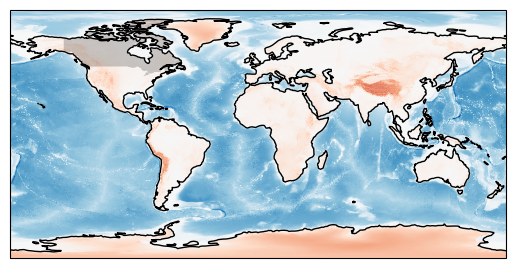

In [17]:
crs = ccrs.PlateCarree()
crs_proj4 = crs.proj4_init
df_pc = df.to_crs(crs_proj4)

fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
ax.coastlines()
df_pc.plot(ax=ax, alpha=0.2, color='black', zorder=1)
var.plot(ax=ax, add_colorbar=False, transform=crs, zorder=0);

### Generate the mask

The `regionmask.mask_geopandas()` method needs the GeoDataFrame of the selected shapefile, longitude and latitude (must be 'lon' and 'lat'). Lon and lat can be generated using np.arange() or here we use the lon and lat arrays of the example Dataset _ds_topo_ to be able to use the `xarray.where()` method later to extract the data for the country.

In [18]:
mask = regionmask.mask_geopandas(df, ds_topo.lon, ds_topo.lat)

**Note:** Instead of getting a mask containing zero and one we get a mask containing NaN and the index number of the country in the GeoDataFrame, e.g. 43 for Canada. 

In [19]:
np.unique(mask)

array([43., nan])

Plot the mask.

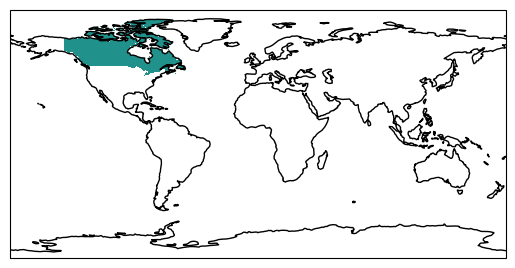

In [20]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

mask.plot(ax=ax,
          transform=ccrs.PlateCarree(),
          add_colorbar=False)

ax.coastlines();

### Mask the data

Now we can use the mask array to extract the values of the variable _topo_ when mask is equal the index of the country (index 43 = Canada).

In [21]:
country_index = df.index.values

In [22]:
masked_data = var.where(mask == country_index)

Plot the masked data.

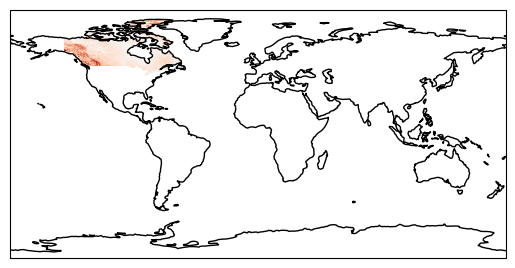

In [23]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

masked_data.plot(ax=ax,
                 transform=ccrs.PlateCarree(),
                 add_colorbar=False)

ax.coastlines();

<br>

## Example 2: Extract the data for German states

This time we use two shapefiles named **gadm36_DEU_0.shp** and **gadm36_DEU_1.shp** that contain the border polygons of Germany and its states.

Read the first shapefile containing the German border polygons.

In [24]:
shp_file0 = './gadm36_DEU_shp/gadm36_DEU_0.shp'

content0 = gpd.read_file(shp_file0)

content0

GID_0   NAME_0                                           geometry
0   DEU  Germany  MULTIPOLYGON (((8.70802 47.68958, 8.70766 47.6...

Plot the GeoDataFrame.

<AxesSubplot: >

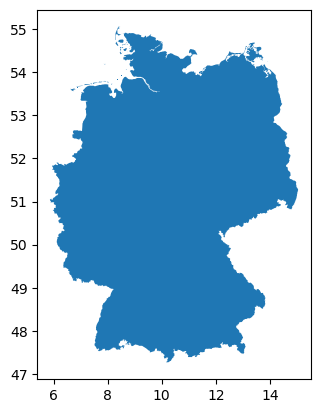

In [25]:
df0 = content0
df0.plot()

Read the second shapefile containing the border polygons of the German states. The names of the German states are stored in the column _NAME_1_.

In [26]:
shp_file1 = './gadm36_DEU_shp/gadm36_DEU_1.shp'

content1 = gpd.read_file(shp_file1)

shp_var1 = 'NAME_1'
states = ['Bayern', 'Baden-Württemberg', 'Rheinland-Pfalz', 'Saarland']

Check if the choosen states are in the shapefile.

In [27]:
# Get list of all states in shapefile.
state_names = [ x for x in content1[shp_var1] ]

# Check if states is in the shapefile.
ncheck = [n for n in state_names if n in states]

if ncheck == []:
    raise NameError(f'ERROR: "{states}" not found in shapefile')
else:
    print(ncheck)

['Baden-Württemberg', 'Bayern', 'Rheinland-Pfalz', 'Saarland']


Extract the pyolgons for the states from the shapefile.

In [28]:
df1 = content1[content1[shp_var1].isin(states)]
df1

GID_0   NAME_0     GID_1             NAME_1             VARNAME_1  \
0    DEU  Germany   DEU.1_1  Baden-Württemberg                   NaN   
1    DEU  Germany   DEU.2_1             Bayern               Bavaria   
10   DEU  Germany  DEU.11_1    Rheinland-Pfalz  Rhineland-Palatinate   
11   DEU  Germany  DEU.12_1           Saarland                   NaN   

    NL_NAME_1     TYPE_1 ENGTYPE_1 CC_1 HASC_1  \
0         NaN       Land     State   08  DE.BW   
1         NaN  Freistaat       NaN   09  DE.BY   
10        NaN       Land     State   07  DE.RP   
11        NaN       Land     State   10  DE.SL   

                                             geometry  
0   MULTIPOLYGON (((8.70802 47.68958, 8.70766 47.6...  
1   POLYGON ((9.74066 47.55354, 9.74058 47.55311, ...  
10  POLYGON ((6.65043 49.54951, 6.65105 49.54793, ...  
11  POLYGON ((6.84393 49.15551, 6.84085 49.15413, ...

### Generate the mask

In [29]:
mask1 = regionmask.mask_geopandas(df1, ds_topo.lon, ds_topo.lat)
mask_id = np.unique(mask1)[0:-1]
mask_id

array([ 0.,  1., 10., 11.])

In [30]:
masked_data1 = var.where(mask1.isin(mask_id))

Plot the chosen German states.

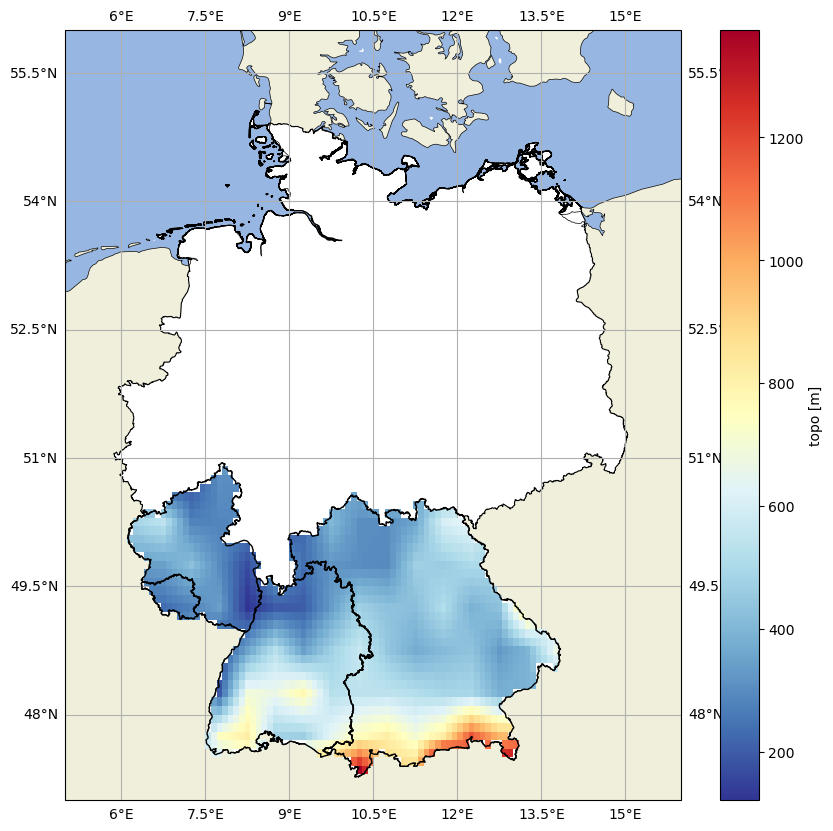

In [31]:
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([5.0, 16.0, 47.0, 56.0], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.coastlines(linewidth=0.5)

# draw Germany in white
df0.plot(ax=ax, color='white', linewidth=0.8, zorder=0)

# draw German border line
df0.boundary.plot(ax=ax, color='black', linewidth=0.8, zorder=1)

# draw masked data of chosen states
masked_data1.plot(ax=ax, cmap='RdYlBu_r', transform=ccrs.PlateCarree(),zorder=2)

# draw state border lines of chosen states
df1.boundary.plot(ax=ax, color='black', linewidth=1., zorder=3);

### Set projection (CRS)

Next, we want to get rid of the 'UserWarning: Geometry is in a geographic CRS.' again we set the projection to ccrs.PlateCarree().

In [32]:
crs = ccrs.PlateCarree()
crs_proj4 = crs.proj4_init
df1_pc = df1.to_crs(crs_proj4)

### Get center position of a state

To add the state name at the center of each state you can use the `GeoDataFrame.centroid` method to retrieve the x- and y-value of their center position.

In [33]:
x = df1_pc.centroid.map(lambda p: p.x)
y = df1_pc.centroid.map(lambda p: p.y)

print(x.values)
print(y.values)

[ 9.04912789 11.41991337  7.44911462  6.9531355 ]
[48.53746029 48.9475745  49.91368885 49.38436768]


### Plotting: Add state names and border lines

Now we can add the state names to the plot.

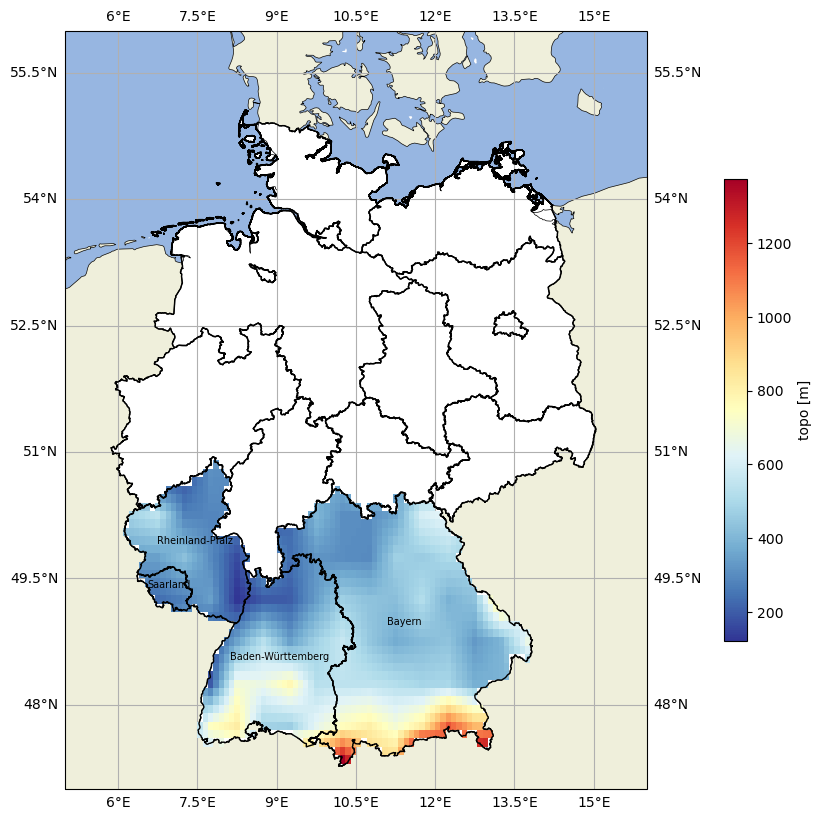

In [34]:
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([5.0, 16.0, 47.0, 56.0], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.coastlines(linewidth=0.5)

# draw Germany in white
df0.plot(ax=ax, color='white', linewidth=0.8, zorder=0)

#draw German border line
df0.boundary.plot(ax=ax, color='black', linewidth=0.8, zorder=1)

# draw masked data of chosen states
masked_data1.plot(ax=ax, cmap='RdYlBu_r', transform=ccrs.PlateCarree(),
                  cbar_kwargs={'orientation':'vertical', 'shrink':0.6, 'pad':0.1},
                  zorder=2)

# draw state border lines
content1.boundary.plot(ax=ax, color='black', linewidth=1., transform=crs, zorder=3)

# add chosen state names
for i in df1_pc.index.values:
    ax.text(x[i], y[i], df1["NAME_1"][i], ha='center', fontsize=7)

Have a short look at the other gadm36_DEU shapefile.

<AxesSubplot: >

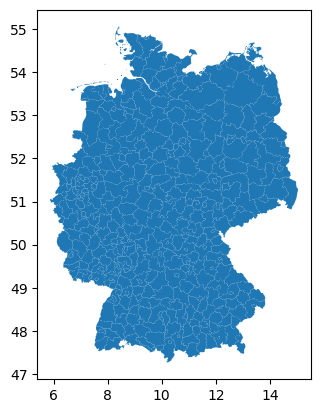

In [35]:
shp_file2 = './gadm36_DEU_shp/gadm36_DEU_2.shp'

content2 = gpd.read_file(shp_file2)

content2.plot()